# MOXSI Full-disk Simulations

This is a visualization of the full-disk observation as derived from a DEM from both XRT and AIA in all seven orders.
This is mainly for the purposes of showing what MOXSI data will look like

In [24]:
import pathlib

import aiapy
import astropy.time
import astropy.units as u
from astropy.visualization import LogStretch, ImageNormalize, AsymmetricPercentileInterval
import distributed
import numpy as np
import matplotlib.pyplot as plt
from overlappy.io import write_overlappogram
from overlappy.util import color_lat_lon_axes

from mocksipipeline.physics.dem.data_prep import DataQuery
from mocksipipeline.physics.spectral import SpectralModel
from mocksipipeline.detector.component import DispersedComponent
from mocksipipeline.util import stack_components

In [2]:
correction_table = aiapy.calibrate.util.get_correction_table() 
error_table = aiapy.calibrate.util.get_error_table()
temperature_bin_edges = 10**np.arange(5.5, 7.6, 0.1) * u.K
ar_time = astropy.time.Time('2020-11-09 18:00:00')
pointing_table = aiapy.calibrate.util.get_pointing_table(ar_time-6*u.h, ar_time+6*u.h)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 100 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 10 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [3]:
data_dir = pathlib.Path('../data/')
top_dir = data_dir / 'observations' / f'ar_{ar_time.isot}'

In [4]:
dq = DataQuery(top_dir,
               ar_time,
               aia_error_table=error_table,
               aia_correction_table=correction_table,
               aia_pointing_table=pointing_table,
               temperature_bin_edges=temperature_bin_edges)

In [5]:
dem_cube = dq.run()

Files Downloaded:   0%|          | 0/7 [00:00<?, ?file/s]

comp_XRT20201109_181902.6.fits:   0%|          | 0.00/4.22M [00:00<?, ?B/s]

aia_lev1_335a_2020_11_09t18_00_00_63z_image_lev1.fits:   0%|          | 0.00/7.01M [00:00<?, ?B/s]

aia_lev1_131a_2020_11_09t17_59_54_61z_image_lev1.fits:   0%|          | 0.00/8.18M [00:00<?, ?B/s]

aia_lev1_193a_2020_11_09t18_00_04_84z_image_lev1.fits:   0%|          | 0.00/10.9M [00:00<?, ?B/s]

3/0 files failed to download. Please check `.errors` for details


Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

aia_lev1_211a_2020_11_09t17_59_57_62z_image_lev1.fits:   0%|          | 0.00/9.31M [00:00<?, ?B/s]

aia_lev1_94a_2020_11_09t17_59_59_12z_image_lev1.fits:   0%|          | 0.00/10.6M [00:00<?, ?B/s]

aia_lev1_171a_2020_11_09t17_59_57_34z_image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.02k/2.02k [02:18<00:00, 14.7 x10^2 DEM/s]


In [6]:
spec_model = SpectralModel()

In [8]:
dem_cube

NDCube
------
Dimensions: [ 20. 450. 450.] pix
Physical Types of Axes: [('phys.temperature',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: 1 / cm5
Data Type: float64

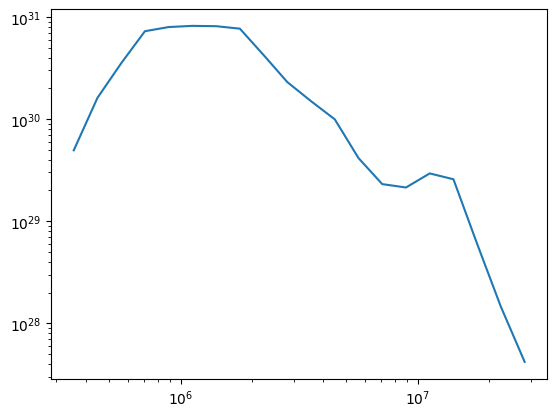

In [59]:
plt.plot(dq.temperature_bin_centers, dem_cube.data.sum(axis=(1,2)))
plt.xscale('log')
plt.yscale('log')

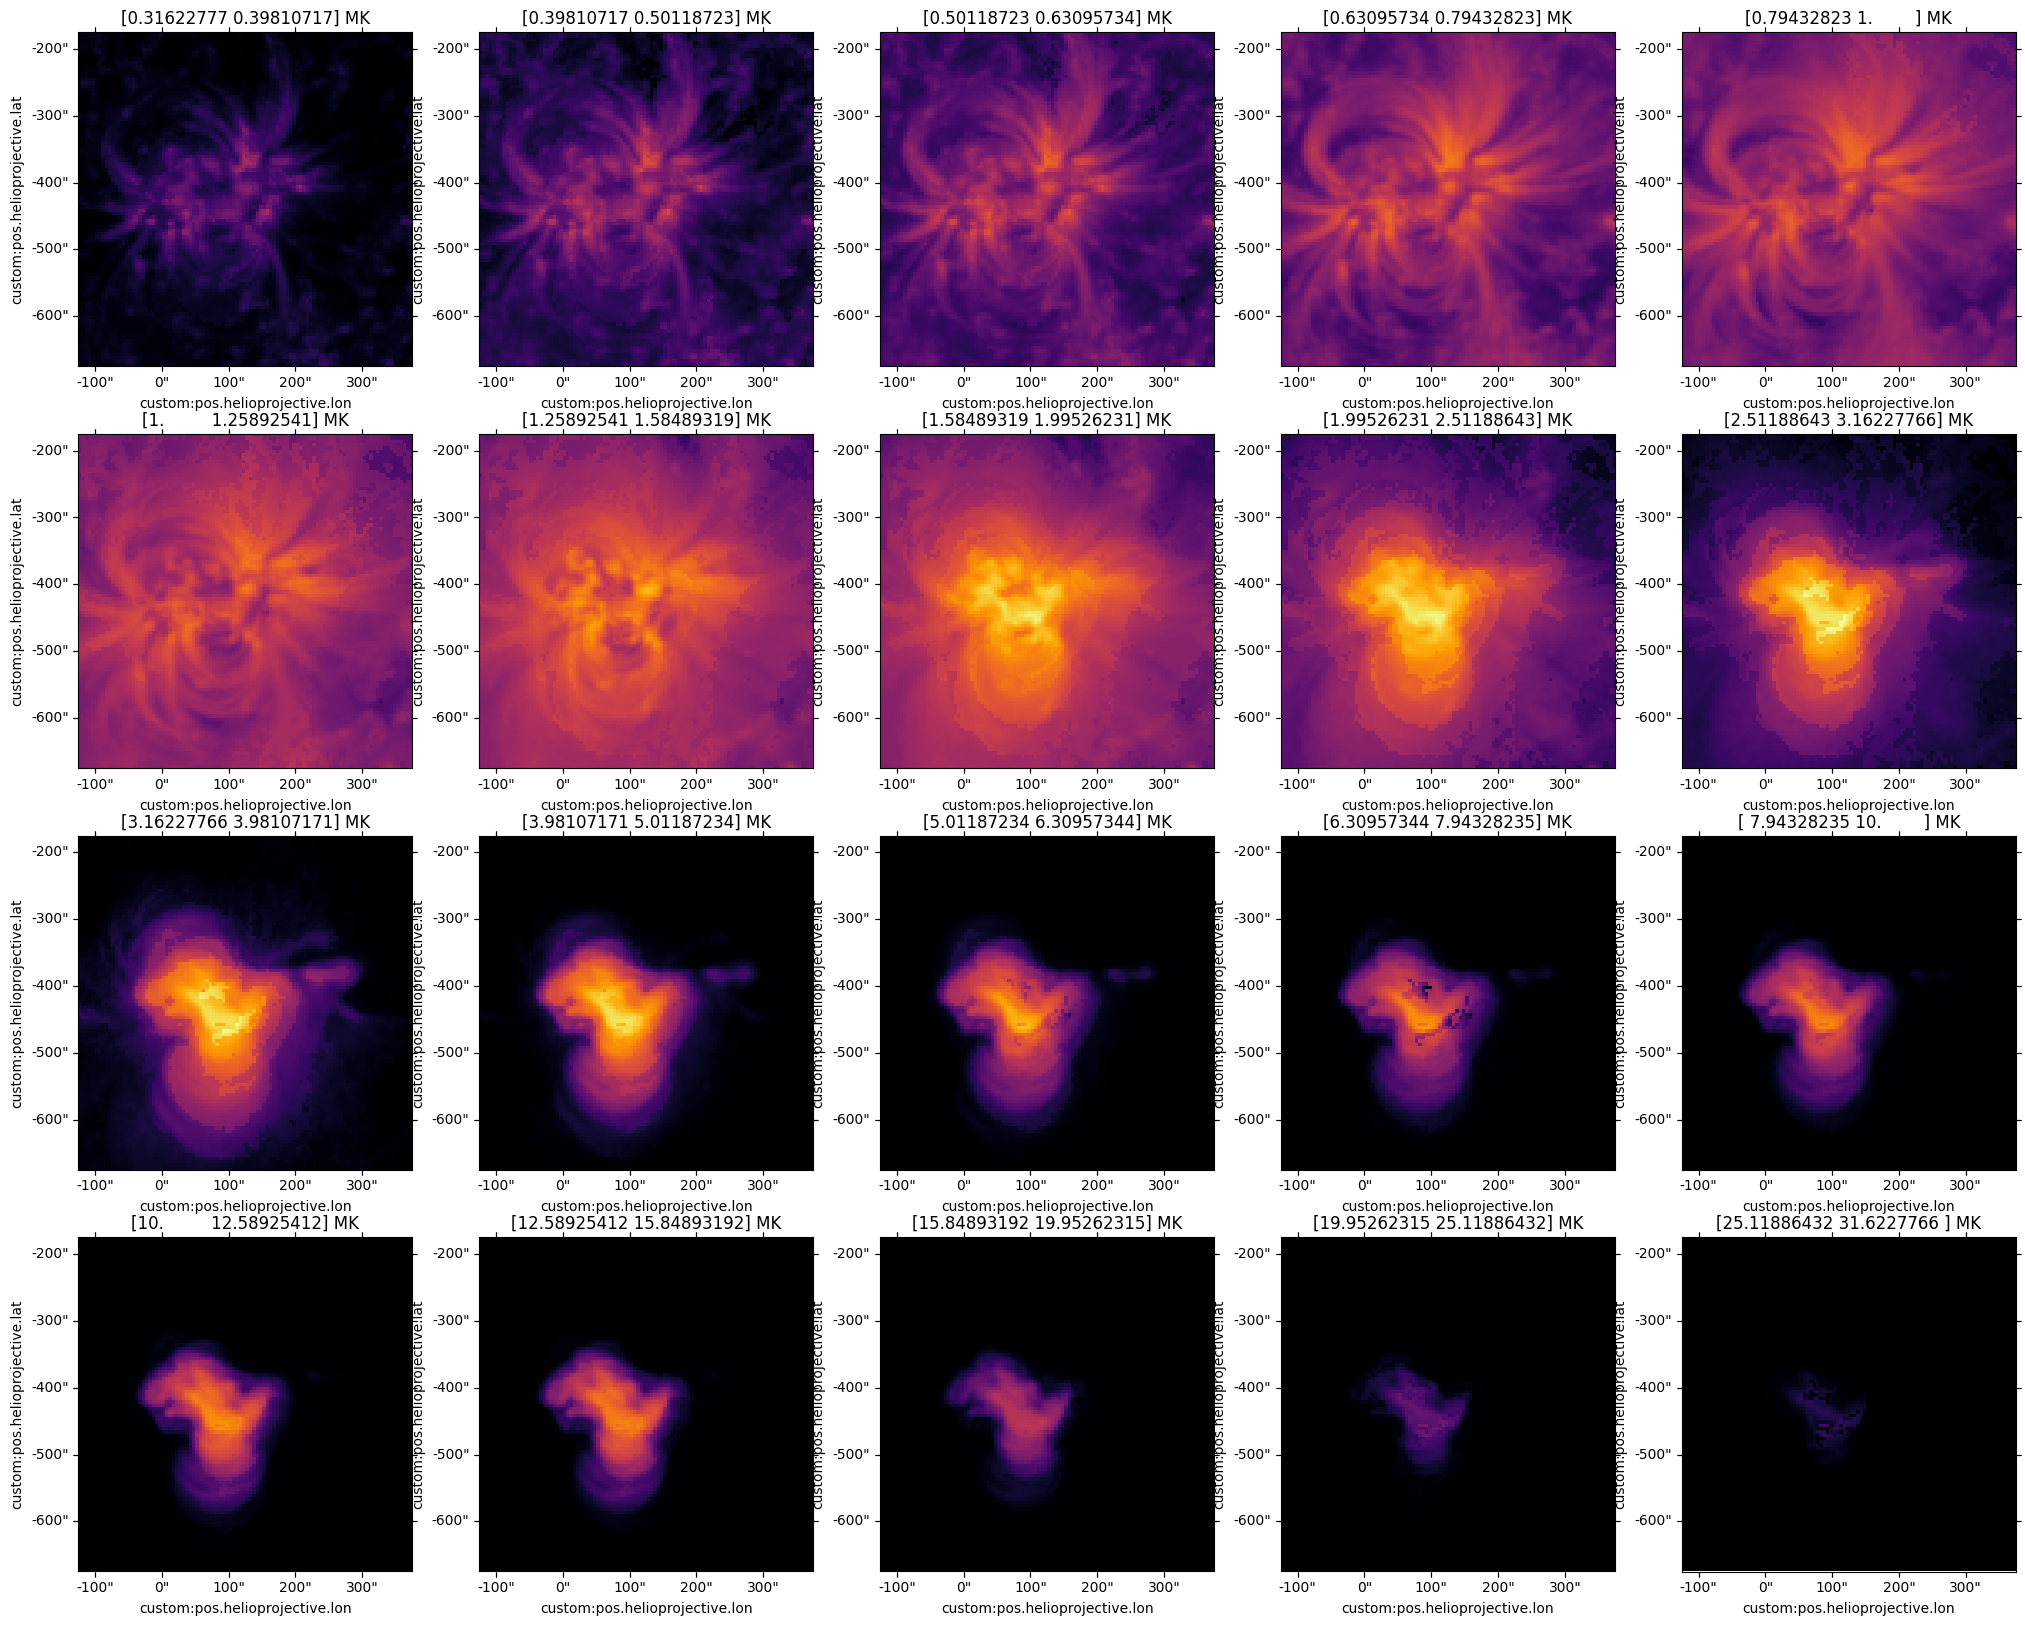

In [103]:
fig = plt.figure(figsize=(25,20))
norm=ImageNormalize(vmin=1e24,vmax=5e27, stretch=LogStretch())
for i,c in enumerate(dem_cube):
    ax = fig.add_subplot(4,5,i+1,projection=c[90:190,200:300].wcs)
    c[90:190,200:300].plot(axes=ax, norm=norm, cmap='inferno')
    ax.set_title(dq.temperature_bin_edges[[i,i+1]].to('MK'))

In [9]:
spec_cube = spec_model.run(dem_cube, dq.celestial_wcs)

In [15]:
dc = DispersedComponent()

In [16]:
client = distributed.Client()

In [17]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54650,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:54666,Total threads: 2
Dashboard: http://127.0.0.1:54672/status,Memory: 12.80 GiB
Nanny: tcp://127.0.0.1:54653,


In [18]:
components = dc.compute(spec_cube, electrons=False)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *ar

In [19]:
components

{-3: <ndcube.ndcube.NDCube object at 0x2e5538eb0>
 NDCube
 ------
 Dimensions: [1255. 1500. 2000.] pix
 Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
 Unit: ph / (pix s)
 Data Type: float64,
 -2: <ndcube.ndcube.NDCube object at 0x301ff2670>
 NDCube
 ------
 Dimensions: [1255. 1500. 2000.] pix
 Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
 Unit: ph / (pix s)
 Data Type: float64,
 -1: <ndcube.ndcube.NDCube object at 0x2fdb2d730>
 NDCube
 ------
 Dimensions: [1255. 1500. 2000.] pix
 Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl'), ('custom:pos.h

In [84]:
total_overlappogram = stack_components([v for k,v in components.items()], wcs_index=4)

In [85]:
total_overlappogram

NDCube
------
Dimensions: [1255. 1500. 2000.] pix
Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: ph / (pix s)
Data Type: float64

In [86]:
wave = components[0].axis_world_coords(0)[0]

In [87]:
i_wave = np.argmin(np.fabs(wave - 22*u.AA))

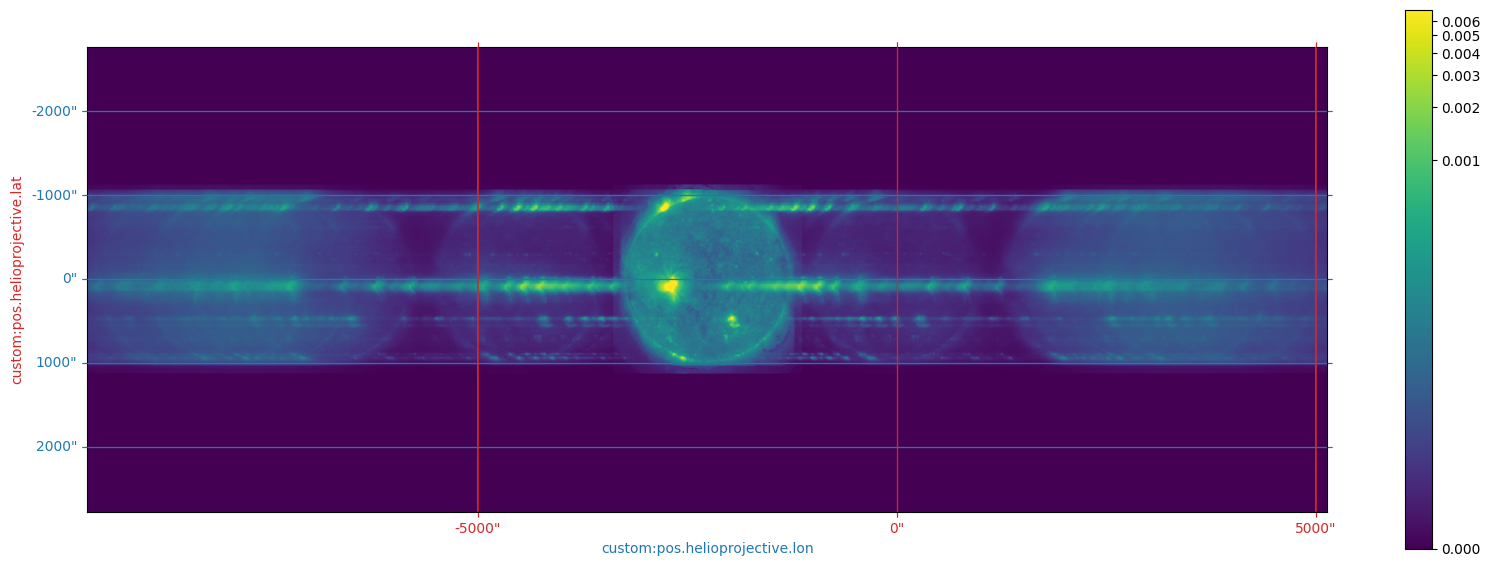

In [88]:
fig = plt.figure(figsize=(20,7))
vmin,vmax = AsymmetricPercentileInterval(1,99.99).get_limits(total_overlappogram[i_wave].data)
#vmin,vmax = None, None
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())
ax = fig.add_subplot(projection=total_overlappogram[i_wave,0:750,:].wcs)
total_overlappogram[i_wave,0:750,:].plot(
    axes=ax,
    norm=norm,
    data_unit='photon / (pix s)',
    cmap='viridis',
)
color_lat_lon_axes(ax)
plt.colorbar()

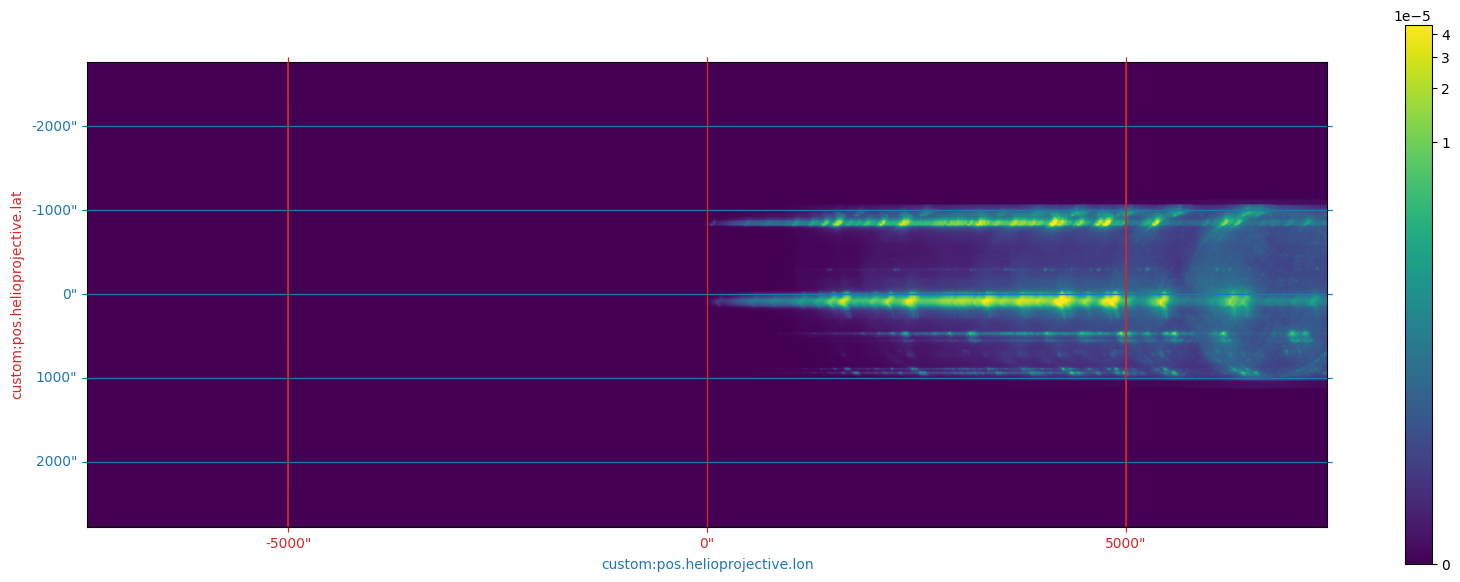

In [90]:
fig = plt.figure(figsize=(20,7))
vmin,vmax = AsymmetricPercentileInterval(1,99.99).get_limits(components[3][0].data)
#vmin,vmax = None, None
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())
ax = fig.add_subplot(projection=components[3][0,0:750,:].wcs)
components[3][0,0:750,:].plot(
    axes=ax,
    norm=norm,
    data_unit='photon / (pix s)',
    cmap='viridis',
)
color_lat_lon_axes(ax)
plt.colorbar()

In [112]:
for k,v in components.items():
    write_overlappogram(v, f'../data/observations/overlappograms_full_disk/overlappogram-order{k}.fits')

In [3]:
2200/6

366.6666666666667